In [2]:
from src.TopoExplanation import *
import networkx as nx
from sklearn.cluster import AgglomerativeClustering
import lime
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from lime.lime_tabular import LimeTabularExplainer
import numpy as np
from sklearn.datasets import make_classification
import shap
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Generate a synthetic data

In [3]:
X, y = make_classification(
    n_samples=500, 
    n_features=2, 
    n_redundant=0,
    n_clusters_per_class=1,
    random_state=0
)

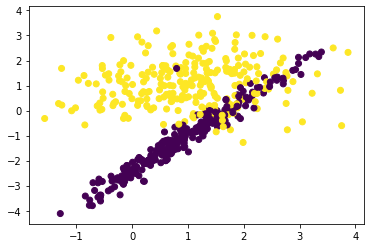

In [4]:
plt.scatter(X[:,0],X[:,1],c=y)

## Train a classifier

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

print('The accuracy of the Random Forests model is :\t',metrics.accuracy_score(pred,y_test))

The accuracy of the Random Forests model is :	 0.9030303030303031


## Generate and visualize LIME explanations

100%|██████████| 165/165 [00:10<00:00, 16.40it/s]


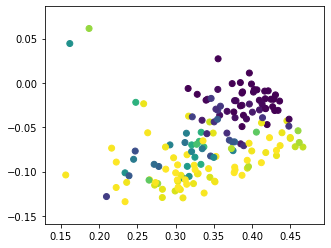

In [7]:
explainer = LimeTabularExplainer(X_train,discretize_continuous=False)
lime_exp = []
for x in tqdm(X_test):
    exp = explainer.explain_instance(x, clf.predict_proba)
    lime_exp.append(exp.as_list())
lime_exp = pd.DataFrame(map(dict,lime_exp)).to_numpy()
plt.figure(figsize=(5,4))
plt.scatter(lime_exp[:,0],lime_exp[:,1],c=pred_prob)

## Generate the visualize SHAP explanations

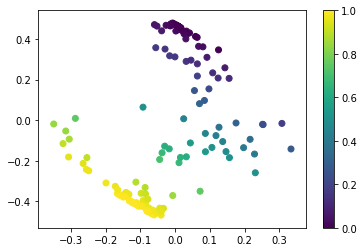

In [8]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_test)
sc = plt.scatter(shap_values[0][:,0],shap_values[0][:,1],c=pred_prob)

plt.colorbar(sc)

## Generate the topological graph for SHAP explanations

In [28]:
pred_prob = clf.predict_proba(X_test)[:,1]
function = pred_prob.reshape(-1,1)
params = {"filters": function, "filter_bnds": np.array([[0,1]]), "colors": function, 
          "resolutions": np.array([10]), "gains": np.array([0.5]), "inp": "point cloud", 
          "clustering": AgglomerativeClustering(n_clusters=None, linkage="single", distance_threshold=0.3)}

M = MapperComplex(**params).fit(shap_values[0])

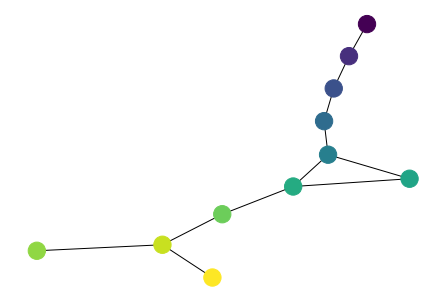

In [31]:
G = mapper2networkx(M)
pos = nx.kamada_kawai_layout(G)
pos = {k:[-v[0],v[1]] for k,v in pos.items()}#flip the graph for consistency
nx.draw(G, pos=pos, 
        node_color=[M.node_info_[node]["colors"][0] for node in G.nodes()])

## Plottings for Pipeline (Figure 3)

### Original data distributions

([], <a list of 0 Text yticklabel objects>)

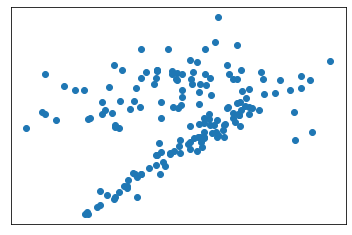

In [27]:
plt.scatter(X_test[:,0],X_test[:,1])
plt.xticks([], [])
plt.yticks([], [])

### Classifier's output

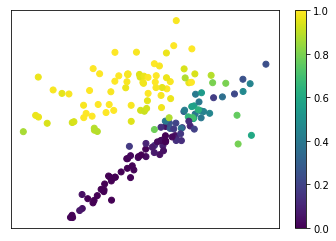

In [28]:
sc = plt.scatter(X_test[:,0],X_test[:,1],c=pred_prob)
plt.xticks([], [])
plt.yticks([], [])
plt.colorbar(sc)

### SHAP's output

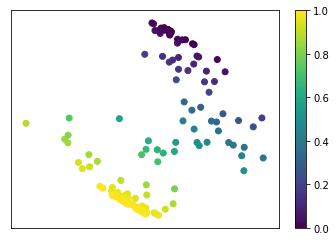

In [37]:
sc = plt.scatter(shap_values[0][:,0],shap_values[0][:,1],c=pred_prob)
plt.xticks([], [])
plt.yticks([], [])
plt.colorbar(sc)

### Persistence Diagram for SHAP's topological graph

In [29]:
dgms = get_persistence_diagrams(M,False)

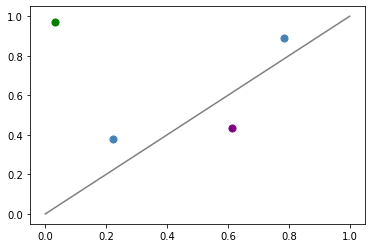

In [30]:
cdict = {0: 'steelblue', 1: 'orange',2:'green',3:'purple'}
for j in range(4):
    xs = [dgms[j][i][0] for i in range(len(dgms[j]))]
    ys = [dgms[j][i][1] for i in range(len(dgms[j]))]
    plt.scatter(xs,
                ys,c=cdict[j],s=50)

# plt.legend(loc='upper right')
plt.plot([0,1],[0,1],c='grey')